In [1]:
from fusions.diffusion import Diffusion
from fusions.cfm import CFM
from lsbi.model import MixtureModel
import numpy as np
import anesthetic as ns

# Setup a problem with lsbi

Five dimensional parameter space

In [2]:
dims = 5
data_dims = dims
np.random.seed(12)

mixtures = 5
A = np.random.randn(mixtures, data_dims, dims)
Model = MixtureModel(
    # M=A,
    M=np.stack([np.eye(dims), -np.eye(dims)]),
    mu=np.zeros(dims),
    Sigma=np.eye(dims),
    m=np.zeros(data_dims),
    C=np.eye(data_dims)*0.1,
)

data = Model.evidence().rvs()



draw the posterior in orange and prior in blue

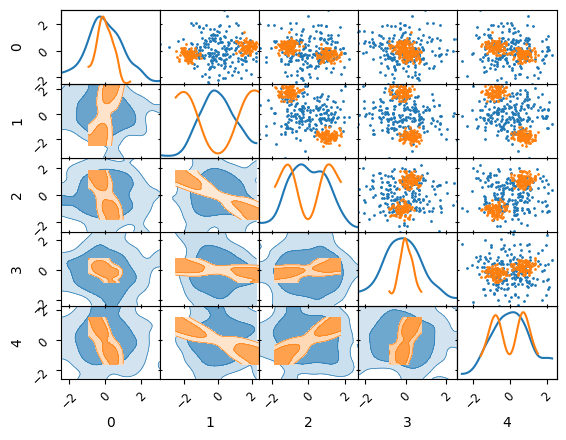

In [3]:
size = 200
P = Model.posterior(data).rvs(size)
theta=Model.prior().rvs(size)
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a= ns.MCMCSamples(P).plot_2d(a)

# Training a diffusion model

Sample from the posterior as training data. Train a Continuous Flow Matching objective

In [12]:
training_data = Model.posterior(data).rvs(size*10)
# diffusion = Diffusion(prior = Model.prior())
diffusion = CFM(prior = Model.prior(), noise=1)

In [18]:
diffusion = CFM(prior = Model.prior(), noise=.1)
diffusion.train(training_data,n_epochs=1000,noise = .5)

100%|██████████| 1000/1000 [00:02<00:00, 460.80it/s]


Now we can compare how well this trained flow approximates the target

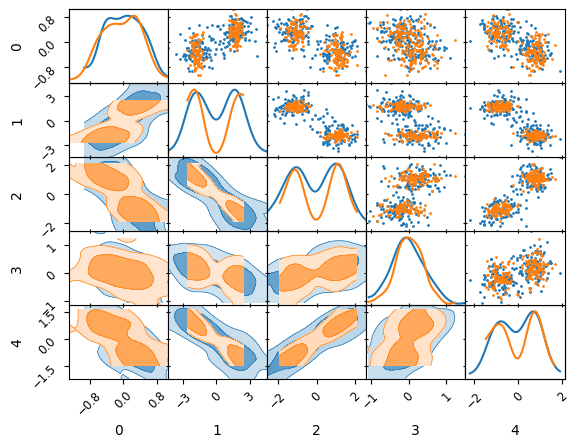

In [19]:
size = 200
P = Model.posterior(data).rvs(size)
theta=diffusion.rvs(size)
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a= ns.MCMCSamples(P).plot_2d(a)

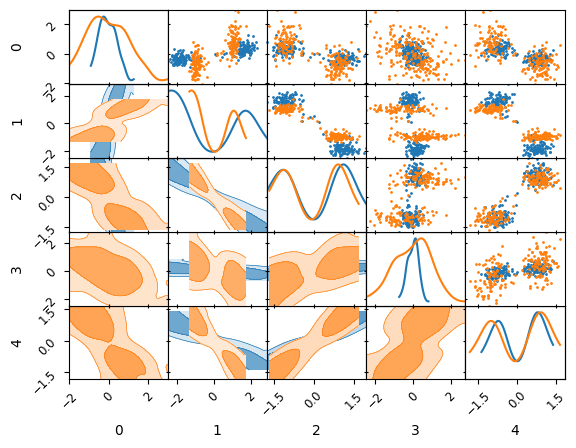

In [10]:
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a = ns.MCMCSamples((theta - theta.mean(axis=0))/theta.std(axis=0)).plot_2d(a)

In [11]:
theta.mean(axis=0)

Array([-0.02794627, -0.17944615,  0.09514809, -0.00022028,  0.0735331 ],      dtype=float32)

# Trajectories in ODE
Of interest to is in how straight lines drawn in either the prior or a gaussian latent space are mapped to the target.

## As a function of "time"
The forward model that the CFM encodes is a neural ODE, we can track the evolution of this as afunction of the time parameter introduced in training

In [7]:
t=Model.prior().rvs(1000)
x_t =diffusion.predict(t, steps=100)

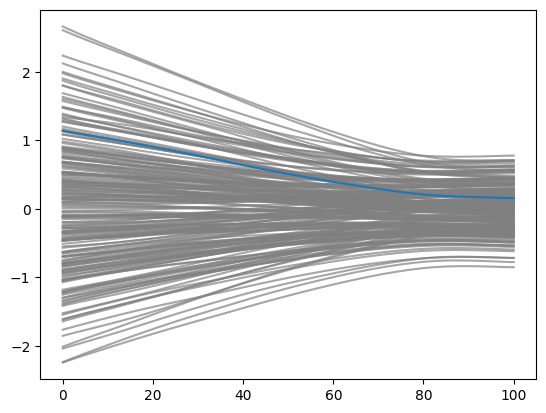

In [8]:
import matplotlib.pyplot as plt
f,a = plt.subplots()
param_idx=3
a.plot(x_t[:199,:,param_idx].T, color="grey", alpha=0.7);
a.plot(x_t[200,:,param_idx], color="C0")

## As a function of path

We can build a set of adjacent points that cuts through our 5d space in a straight line from either
* [-1,-1,-1,-1,-1] to [1,1,1,1,1] 

or

* [-1,0,0,0,0] to [1,1,1,1,1]

and then examine what it looks like after being diffused

In [9]:
line_x = np.linspace(-1,1,50)
line_y=np.zeros((line_x.shape[0], 4))
test_x=np.repeat(line_x[...,None], 5, axis=1)
# test_x=np.concatenate([np.atleast_2d(line_x),line_y.T]).T
target_x=diffusion.predict(test_x, steps=100)

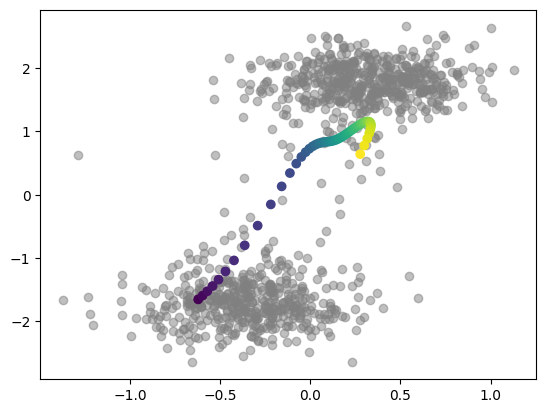

In [10]:
param_idx = 0
plt.scatter(x_t[...,-1,param_idx], x_t[...,-1,param_idx+1], c="grey", alpha=0.5)
plt.scatter(target_x[:,-1,param_idx], target_x[:,-1,param_idx+1], c= np.arange(len(line_x)))


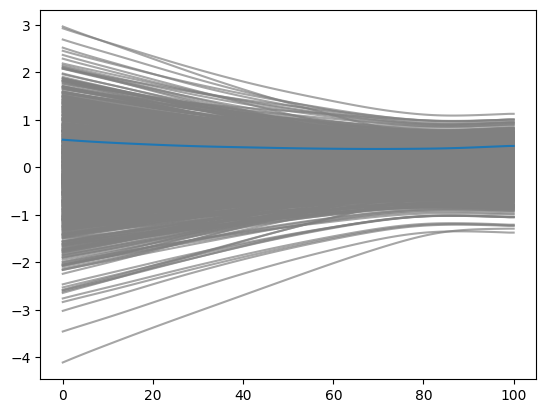

In [11]:
f,a = plt.subplots()
param_idx=0
a.plot(x_t[199:,:,param_idx].T, color="grey", alpha=0.7);
a.plot(x_t[200,:,param_idx], color="C0")

## Computing volumes

In [12]:
initial_points = Model.prior().rvs(100)

In [13]:
from timeit import default_timer as timer
times_exact = []
js_exact = []
for i in range(10):
    timer_start = timer()
    target_x, J_exact=diffusion.predict(initial_points,jac=True,solution="exact")
    times_exact.append(timer()-timer_start)
    js_exact.append(J_exact)


In [14]:
# from timeit import default_timer as timer
times_approx = []
js_approx = []
for i in range(10):
    timer_start = timer()
    target_x, J_approx=diffusion.predict(initial_points,jac=True,solution="approx")
    times_approx.append(timer()-timer_start)
    js_approx.append(J_approx)


In [15]:
times_none = []
for i in range(10):
    timer_start = timer()
    target_x, J_exact=diffusion.predict(initial_points,jac=True,solution="none")
    times_none.append(timer()-timer_start)

Text(0, 0.5, 'time per 100 evals (s)')

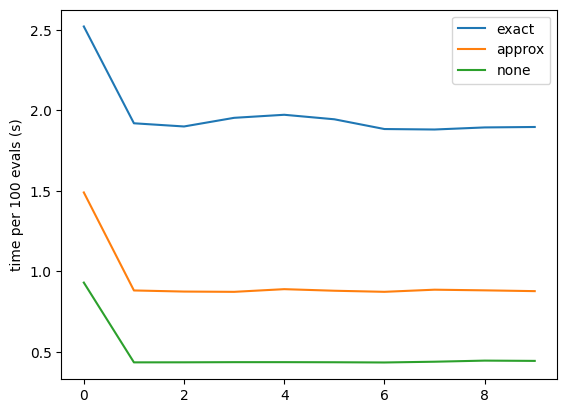

In [16]:
plt.plot(times_exact, label="exact")
plt.plot(times_approx, label="approx")
plt.plot(times_none, label="none")
plt.legend()
plt.ylabel("time per 100 evals (s)")

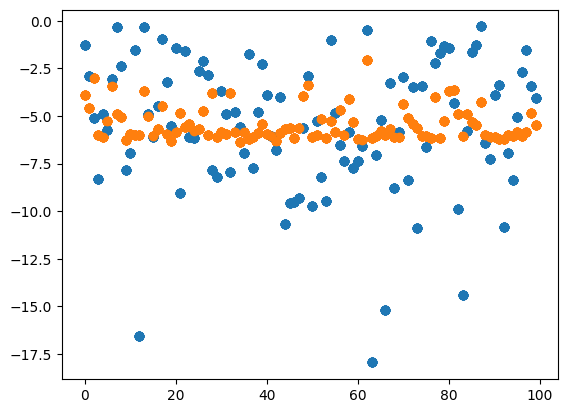

In [17]:
for i, _ in enumerate(js_approx):
    plt.scatter(np.arange(len(initial_points)), js_approx[i], label="approx",color="C0")
    plt.scatter(np.arange(len(initial_points)), js_exact[i], label="exact",color="C1")
